In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy
import datetime

# third party packages
from PIL import Image

# from my code
from src import repo_tools, data_tools, image_tools, signals_processing_tools, carbon_calculation_tools

### Import all battery and carbon intensity data previously processed and saved as .csv

In [2]:
battery_dtypes = {"datetime" : "str", 
                  "ChargingRate(kW)" : "float",
                  "DisChargingRate(kW)" : "float", 
                  "NetChargingRate(kW)": "float"}
parse_dates = ['datetime']
battery_filename = os.path.join("data", "all_battery_data.csv")

all_battery_data = pd.read_csv(battery_filename, header=0, names=battery_dtypes.keys(), dtype=battery_dtypes, parse_dates=parse_dates)

In [3]:
ci_dtypes = {"Actual Carbon Intensity (gCO2/kWh)" : "float", 
             "Forecast Carbon Intensity (gCO2/kWh)" : "float",
             "Index" : "str", 
             "datetime": "str"}
parse_dates = ['datetime']
ci_filename = os.path.join("data", "all_ci_data.csv")

all_ci_data = pd.read_csv(ci_filename, header=0, names=ci_dtypes.keys(), dtype=ci_dtypes, parse_dates=parse_dates)

## Look at the data for a given day

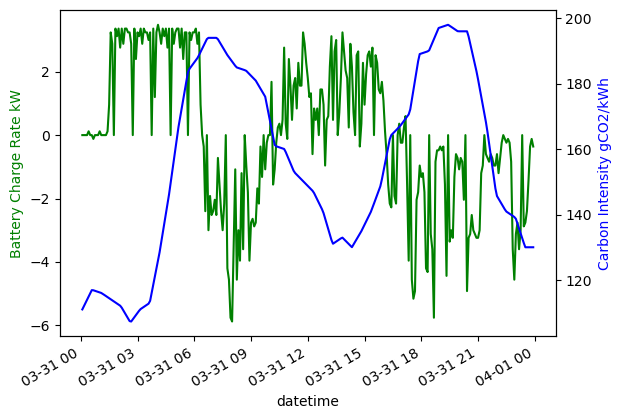

In [8]:
ci_batt_data_22_03_31 = data_tools.prepare_ci_and_battery_data(day_str="2022-03-31", 
                                                                      battery_data=all_battery_data, 
                                                                      ci_data=all_ci_data)

fig,ax1 = plt.subplots()

ax1.plot(ci_batt_data_22_03_31["datetime"], ci_batt_data_22_03_31["battery_power_consumption/kW"], color='g')
ax1.set_xlabel("datetime")
ax1.set_ylabel("Battery Charge Rate kW", color='g')

ax2=ax1.twinx()
ax2.plot(ci_batt_data_22_03_31['datetime'], ci_batt_data_22_03_31['act_carbon_intensity/(gCO2/kWh)'], color='b')
ax2.set_ylabel("Carbon Intensity gCO2/kWh", color='b')
plt.gcf().autofmt_xdate()

carbon_calculation_tools.calculate_carbon_from_day(ci_batt_data_22_03_31)
plt.savefig("images/example_24hour_cycle_CI_and_battery_data.png")

# optimise the charging/discharging strategy of the battery

Logic to consider:

 * Discharge can only occur if there is charge in the battery
 * Charge cannot be negative
 * There is a maximum charge rate of 3kW
 * Unsure of maximum discharge rate
 * What is the underlying power consumption? For now I will pretend it is sinusoidal-ish
 

## Defining the opimisation challenge as a linear problem

Variable definitions:

$p_+(t)$ = battery charging rate at time $t$ /kW  
$p_-(t)$ = battery discharging rate at time $t$ /kW  
$c(t)$ = charge in battery at time $t$ /kWh  
$i(t)$  = carbon intensity of grid at time $t$ /(gCO2/kWh)    
$t$   = time after midnight /hours  
$\mathbf{t}$ = column vector of all times in the day


$\begin{array}{rlll}\min & f ( p_+(\mathbf{t}), p_-(\mathbf{t}), i(\mathbf{t})) & \\ \text { subject to } 
& 
p_+(t) <= 3
\\
&
p_+(t) >= 0
\\
& 
p_-(t) >= 0
\\
&
c(t) >= 0
&
\text { for } i=1, \ldots, n 
& 
\text { Equality constraints } 
\\
&
h_j(\mathbf{x}) \geqq d_j \quad 
&
\text { for } j=1, \ldots, m \quad 
&
\text { Inequality constraints }\end{array}$

In [5]:
problem_definitions = {"max_charge_power/kW" : 3,
              "max_charging_capacity/kWh": 15,
              "charge_at_start_of_day": 0}

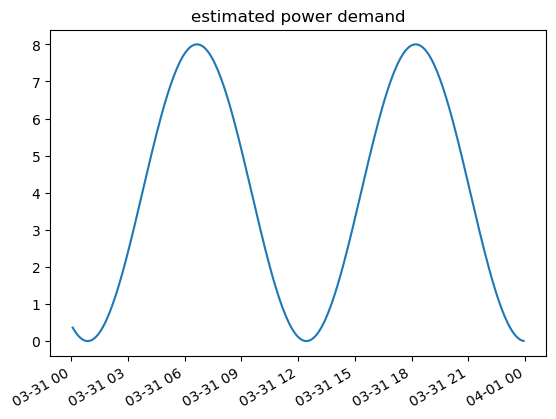

In [6]:
times = ci_batt_data_22_03_31["datetime"].to_numpy()
power_demand = np.array(np.sin([i*13/len(times)-2 for i in range(len(times))])) + 1 # specifically designed
power_demand = power_demand * 4 # to convert to something looking like kW
plt.plot(times, power_demand)
plt.title("estimated power demand")
plt.gcf().autofmt_xdate()


In [7]:
charge = problem_definitions["charge_at_start_of_day"]
